# Connectivity Inference V2

This notebook applied the V2 of the connectivity inference on the adEx implementation of Taehoon of "Susin, Eduarda, and Alain Destexhe. 2021."

In [1]:
############################
######## SETUP  ###########

#####  General Imports ######
import numpy as np
from brian2 import *
from matplotlib import pyplot
import sys
import networkx

##### setup interactive ####
%matplotlib notebook 

In [2]:
#### Simulation Scripts #####
sys.path.append('../simulations/')
from wp2_adex_model_script import * 

###### Utility Scripts #####
sys.path.append('../tools')
import adEx_util as  adEx_util

In [3]:
###########################
####### RUN SIMULATION ####

### choose parameters ###
params = dict()
params['sim_time'] = float(10) # simulation time in seconds 

# taehoons parameters
params['a'] = float(1) # subthreshold adaption constant   [nS] [VALUE: 6ns for destexhe 2009]
params['b'] = float(5) # spike-triggert adaption constant [pA] [VALUE: 6ns for   2009]

params['N'] = int(100) #  no of neurons

# taehoons parameters: max-monosynaptic, yet not saturated  (or ge 10, gi 65)
params['ge']=float(30) # excitatory synaptic conductance [nS] - [VALUE: 6ns for destexhe 2009]
params['gi']=float(67) # inhibitory synaptic conductance [nS] - [VALUE: 67nS for Destexhe (for small scale simulations << 10000 neuron]

root_dir = 'simData'

curr_dir = root_dir + '/' + str(params['N'])

#if(not(os.path.exists(curr_dir))):
#    os.makedirs(curr_dir)

params['save_fol'] = curr_dir


# run simulation
#trace, spikes, S = simpleNetV2(n, p, c, t, ws, tauw, a, b, Vr) # Regular spiking 
result = run_sim(params)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]


The time difference is : 14.748825741999998
[3.1000e+00 3.1000e+00 3.1000e+00 ... 9.9995e+03 9.9997e+03 9.9998e+03]
[ 1.4  5.9 16.9 17.  20.5 21.6 26.  32.3 33.  52.  52.9 62.7 67.  76.
 78.1 78.9 80.3 93.1]
simulation successfullly ran for 100_1.0_5.0_10.0_30.0_67.0


<IPython.core.display.Javascript object>


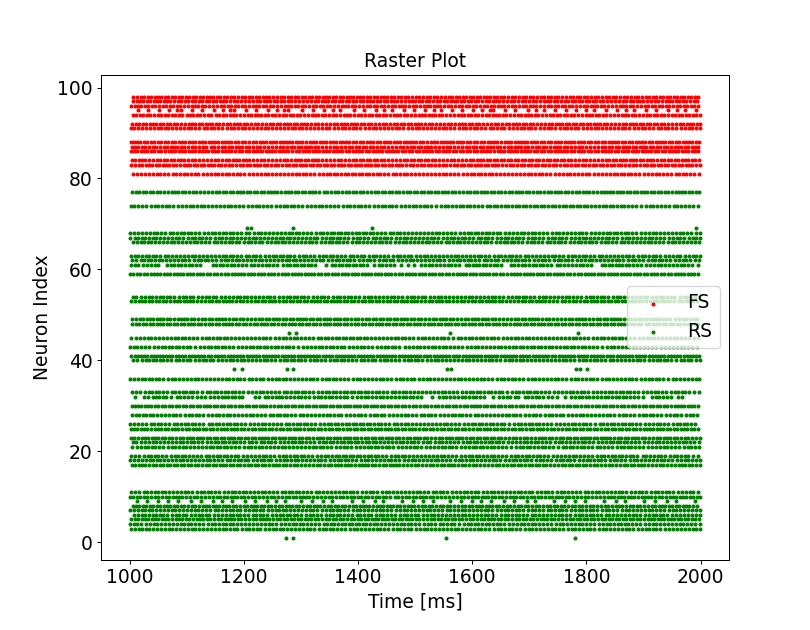

<IPython.core.display.Javascript object>


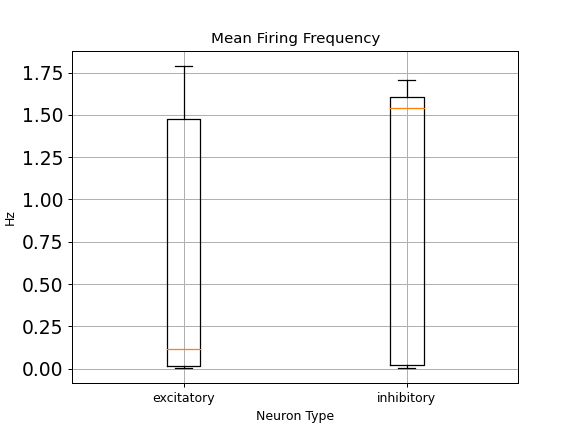

In [4]:
###########################
####### SHOW DATA #########

##### raster plot
# filter for timeframe x-y ms
x = 1000
y = 2000

in_time_sub = result['in_time'][((result['in_time'] > x) & (result['in_time'] < y) )]
in_idx_sub = result['in_idx'][((result['in_time'] > x) & (result['in_time'] < y) )]

ex_time_sub = result['ex_time'][((result['ex_time'] > x) & (result['ex_time'] < y) )]
ex_idx_sub = result['ex_idx'][((result['ex_time'] > x) & (result['ex_time'] < y) )]

#plot
Fig=plt.figure(figsize=(9,7))
plt.subplots_adjust(hspace=0.7, wspace=0.4)

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 


figa=Fig.add_subplot()
plt.title('Raster Plot', fontsize=15)
plt.scatter( in_time_sub, in_idx_sub, color='red',s=5,label="FS")
plt.scatter(  ex_time_sub, ex_idx_sub, color='green',s=5,label="RS")
plt.legend(loc='best', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.ylabel('Neuron Index', fontsize=15) 

##### mean fireing freq.

## individual neurons
#fig = pyplot.figure(figsize=(9,4))

index, counts = np.unique( result['ex_idx'], return_counts=True)
rates_Hz_ex = np.asarray(counts/1000)
#pyplot.scatter(rates_Hz_ex, index , s=15, c=[[.4,.4,.4]], label="RS")

index, counts = np.unique(result['in_idx'], return_counts=True)
rates_Hz_in = np.asarray(counts/1000)
#pyplot.scatter(rates_Hz_in, index , s=15, c=[[.4,.4,.4]], label="FS")


#pyplot.yticks(np.arange(0,result['NI']+result['NE'], 1)) # tick every 1 neuron(s)
#pyplot.xlim([0,200])
#pyplot.ylabel('IDs')
#pyplot.xlabel('Mean firing freq. [Hz]')
#pyplot.title('Mean firing frequency')
#pyplot.grid()
#pyplot.show()

#### per neuron group
fig7, ax7 = plt.subplots()

#data = np.concatenate((rates_Hz_ex, rates_Hz_in))
green_diamond = dict(markerfacecolor='g', marker='D')
data = [rates_Hz_ex, rates_Hz_in]
ax7.set_title('Mean Firing Frequency')
bp = ax7.boxplot(data, flierprops=green_diamond)
ax7.set_xticklabels(("excitatory", "inhibitory"), size=10)
ax7.set_xlabel('Neuron Type')
ax7.set_ylabel('Hz')
ax7.grid()

Mean firing frequency still seems to low. - would expect 1-20 Hz as told in destexhe 2009.

In [5]:
#############################
##### Unpack data ###########
# unpack spikes
times=numpy.append( result['in_time'],  result['ex_time']) # [s]
ids=numpy.append(result['in_idx'],  result['ex_idx'])  
nodes=numpy.arange(0, params['N'], 1)

In [6]:
#############################
###### Infer. Fn. Conn ######

#Note: Conncectvity can only be inferred for the neurons that have at least one spike.
#      Neurons of no single spike are not shown in the graph.

# conversions fom Brain2 --> sPYcon
times_in_sec = (times) /1000 # convert to unitless times from [ms] -> [s]

# import inference method
sys.path.append('../tools/spycon/src')
from sci_sccg import Smoothed_CCG

# define inference method
coninf = Smoothed_CCG() # English2017

# get ground truth graph of network
marked_edges, nodes = adEx_util.make_marked_edges_TwoGroups(ids,result['conn_ee'], result['conn_ei'], result['conn_ii'], result['conn_ie'])

### get conncectivity test 
from spycon_tests import load_test, ConnectivityTest
# define test
spycon_test = ConnectivityTest("spycon_test",times_in_sec, ids, nodes, marked_edges)
# run test
spycon_result, test_metrics = spycon_test.run_test(coninf, only_metrics=False, parallel=True,)

78925


<IPython.core.display.Javascript object>


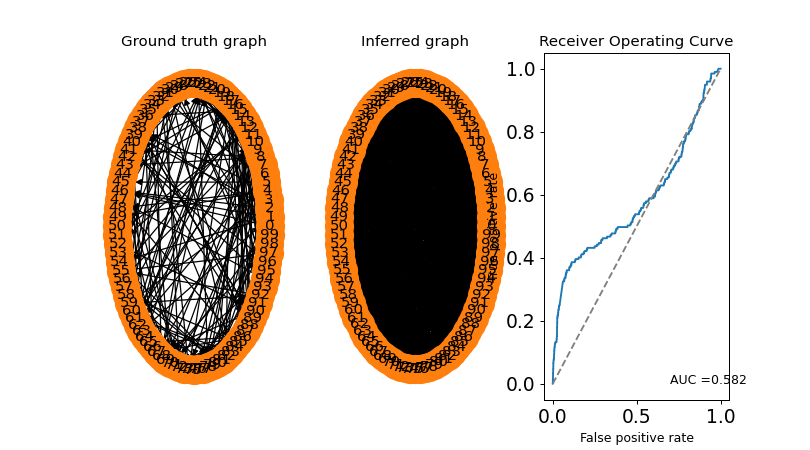

In [7]:
fig = pyplot.figure(figsize=(9,5))
ax1 = fig.add_subplot(131)
spycon_test.draw_graph()
pyplot.title('Ground truth graph')
ax2 = fig.add_subplot(132)
spycon_result.draw_graph(graph_type='binary', ax=ax2)
pyplot.title('Inferred graph')
ax3 = fig.add_subplot(133)
fpr, tpr, auc = tuple(test_metrics[['fpr', 'tpr', 'auc']].to_numpy()[0])
pyplot.plot(fpr, tpr)
pyplot.plot([0,1],[0,1], color='gray', linestyle='--')
pyplot.text(.7,.0,'AUC =%.3f' %auc)
pyplot.xlabel('False positive rate')
pyplot.ylabel('True positive rate')
pyplot.title('Receiver Operating Curve')
pyplot.show()

<IPython.core.display.Javascript object>


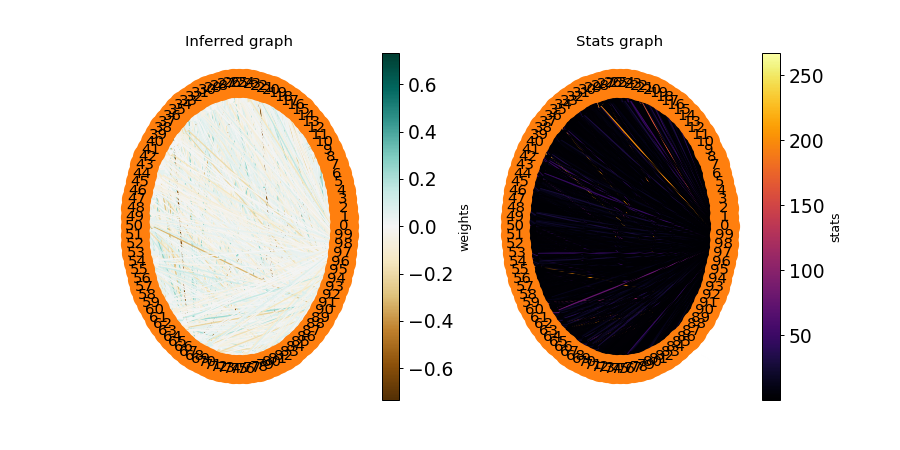

In [8]:
fig = pyplot.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
spycon_result.draw_graph(graph_type='weighted', ax=ax1)
ax1.set_title('Inferred graph')
ax2 = fig.add_subplot(122)
spycon_result.draw_graph(graph_type='stats', ax=ax2)
ax2.set_title('Stats graph')
pyplot.show()

In [9]:
###############################
###### Cross-Correlation ######

# Adding Cross-Correlation methods from "Methods_Viz" from Christian's code
# Needs to work through properly !!

def visualization_english(Smoothed_CCG, times1: numpy.ndarray, times2: numpy.ndarray,
                  t_start: float, t_stop: float) -> (numpy.ndarray):

    kernel = Smoothed_CCG.partially_hollow_gauss_kernel()
    counts_ccg, counts_ccg_convolved, times_ccg = Smoothed_CCG.compute_ccg(times1, times2, kernel, t_start, t_stop)
    
    return counts_ccg, counts_ccg_convolved, times_ccg 

Note the default params of Smoothed_CCG -> especially the binsize

```python
default_params = {'binsize': .4e-3,
                               'hf': .6,
                               'gauss_std': 0.01,
                               'syn_window': (.8e-3,2.8e-3),
                               'ccg_tau': 20e-3,
                               'alpha': .01}
```

Taehoon recommended to use 0.5ms to 1ms as a bin size. Need to fix parameters first.

## The follwing CCG is only created for the case that the ground truth has an actual edge

<IPython.core.display.Javascript object>


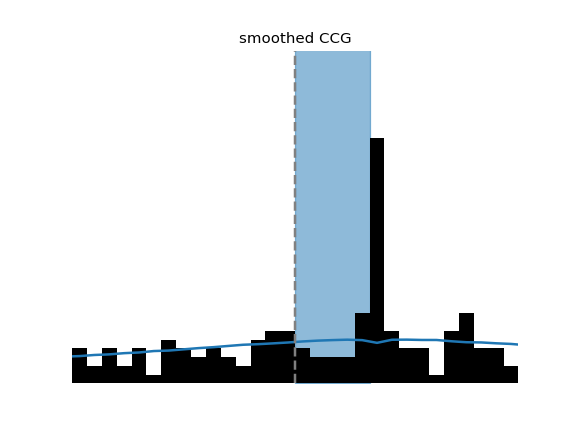

Text(0.5, 1.0, 'smoothed CCG')

In [264]:
## get edges and ids
# get rows/indices of marked_edges that contain connections
edges = numpy.where(numpy.logical_and(spycon_test.marked_edges[:,2] != 0, numpy.logical_not(numpy.isnan(spycon_test.marked_edges[:,2]))))[0]
# select arbitrary edge by order in marked edges
idx = 4
# get pre- and post-synaptic neuron to do the CCH for
id1, id2 = spycon_test.marked_edges[edges[idx],:2]

## run corr correlation 
times1, times2 = spycon_test.times[spycon_test.ids == id1], spycon_test.times[spycon_test.ids == id2]
counts_ccg, counts_ccg_convolved, times_ccg = visualization_english(coninf, times1, times2, 0, 3600)

# plot
fig = pyplot.figure()
ax = pyplot.subplot(111)
ax.axis('off')
ax.fill_between([coninf.default_params['syn_window'][0] * 1e3, coninf.default_params['syn_window'][1] * 1e3], 0, numpy.amax(counts_ccg) + 20, color='C0', alpha=.5)
ax.bar(times_ccg * 1e3, counts_ccg, width=coninf.default_params['binsize'] * 1e3, color='k', label='Data CCG')
ax.plot(times_ccg * 1e3, counts_ccg_convolved, 'C0', label='Smoothed CCG', lw=2)
ax.vlines([0], 0, numpy.amax(counts_ccg) + 20, lw=2, ls='--', color='gray')
ax.hlines(40,-12,-8, 'r')
ax.text(-10, 47, '5 ms', color='r')
#ax.legend()
ax.set_xlim([-15,15])
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Spike count')
ax.set_ylim([0,numpy.amax(counts_ccg) + 10])
ax.set_title('smoothed CCG')

<IPython.core.display.Javascript object>


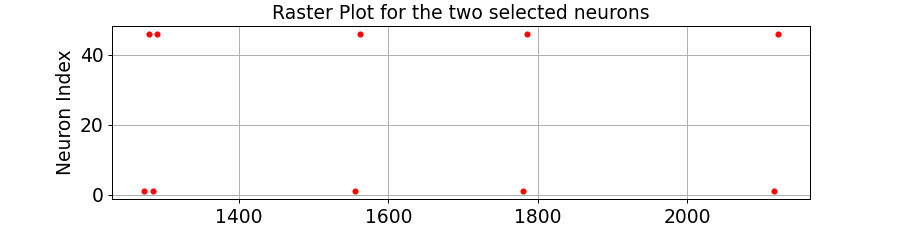

In [273]:
##### plot raster of the two neurons
# filter for timeframe x-y ms
x = 1000
y = 3000

times_frame = times[((times > x) & (times < y) )]
ids_frame = ids[((times > x) & (times < y) )]


#plot
Fig=plt.figure(figsize=(10,2.5))
plt.subplots_adjust(hspace=0.1, wspace=0.5)

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 


figa=Fig.add_subplot()
plt.title('Raster Plot for the two selected neurons', fontsize=15)
plt.scatter(
    times_frame[(ids_frame==id1) | (ids_frame == id2 )],
    ids_frame[(ids_frame==id1) | (ids_frame == id2 )],
    color='red',
    s=15,
    label="")
#plt.scatter(  ex_time_sub, ex_idx_sub, color='green',s=5,label="RS")
#plt.legend(loc='best', fontsize=15)
plt.xlabel('Time [ms]', fontsize=15)
plt.ylabel('Neuron Index', fontsize=15) 
plt.grid()


<IPython.core.display.Javascript object>


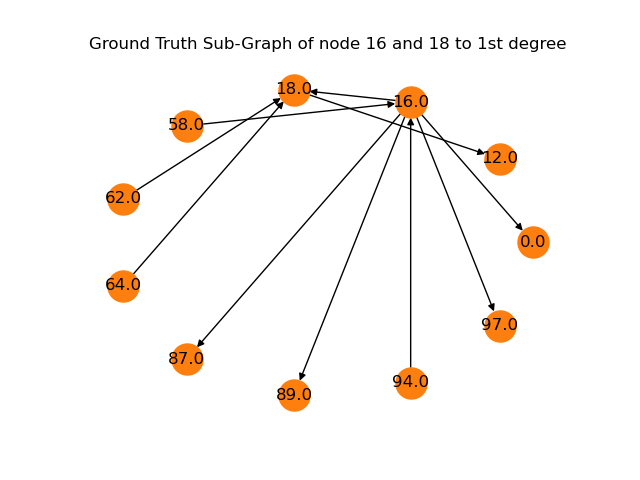

Text(0.5, 1.0, 'Ground Truth Sub-Graph of node 16 and 18 to 1st degree')

In [315]:
###### Show the Ground Truth Graph of edge shown in above CCG - subgraph to first degree with respect to the two nodes
## select for all nodes directly conncected to the two nodes we 
## get nodes that are connected to neuron 1 or neuron 2

#get boolean map (if edge contains node 1)
mapEdgesToid1  = (
                (spycon_test.marked_edges[edges,:1] == id1) | (spycon_test.marked_edges[edges,1:2] == id1)
                )
#get edges condoining node 1
edgesToid1=spycon_test.marked_edges[edges,:][numpy.where(mapEdgesToid1),:2][0] # doubt why do I need the [0]
connsToid1 = edgesToid1.tolist() 

# get nodes of first degree to node 1 
nodes1degid1 = np.unique(connsToid1) 

#get boolean map (if edge contains node 2)
mapEdgesToid2  = (
                (spycon_test.marked_edges[edges,:1] == id2) | (spycon_test.marked_edges[edges,1:2] == id2) # doubt why do I need the [0]
                )
#get edges condoining node 3
edgesToid2 = spycon_test.marked_edges[edges,:][numpy.where(mapEdgesToid2),:2][0]
connsToid2 = edgesToid2.tolist()
# get nodes of first degree to node 2
nodes1degid2 = np.unique(connsToid2) 

# get nodes of first degree to node 2
nodes1deg = np.unique(np.append(nodes1degid1, nodes1degid2)) 


import networkx as nx

#make graph
nxgraph = nx.DiGraph()
#add nodes
nxgraph.add_nodes_from(nodes1deg)
# add edges
nxgraph.add_edges_from(edgesToid1) # from node 1
nxgraph.add_edges_from(edgesToid2) # from node 2

graph = nxgraph

# plot
fig = pyplot.figure()
ax = pyplot.subplot(111)
nx.draw_circular(graph, ax=ax, with_labels=True, node_size=500, node_color='C1')
ax.set_title(f'Ground Truth Sub-Graph of node {int(id1)} and {int(id2)} to 1st degree')


### plot CCGs for all true edges

<IPython.core.display.Javascript object>


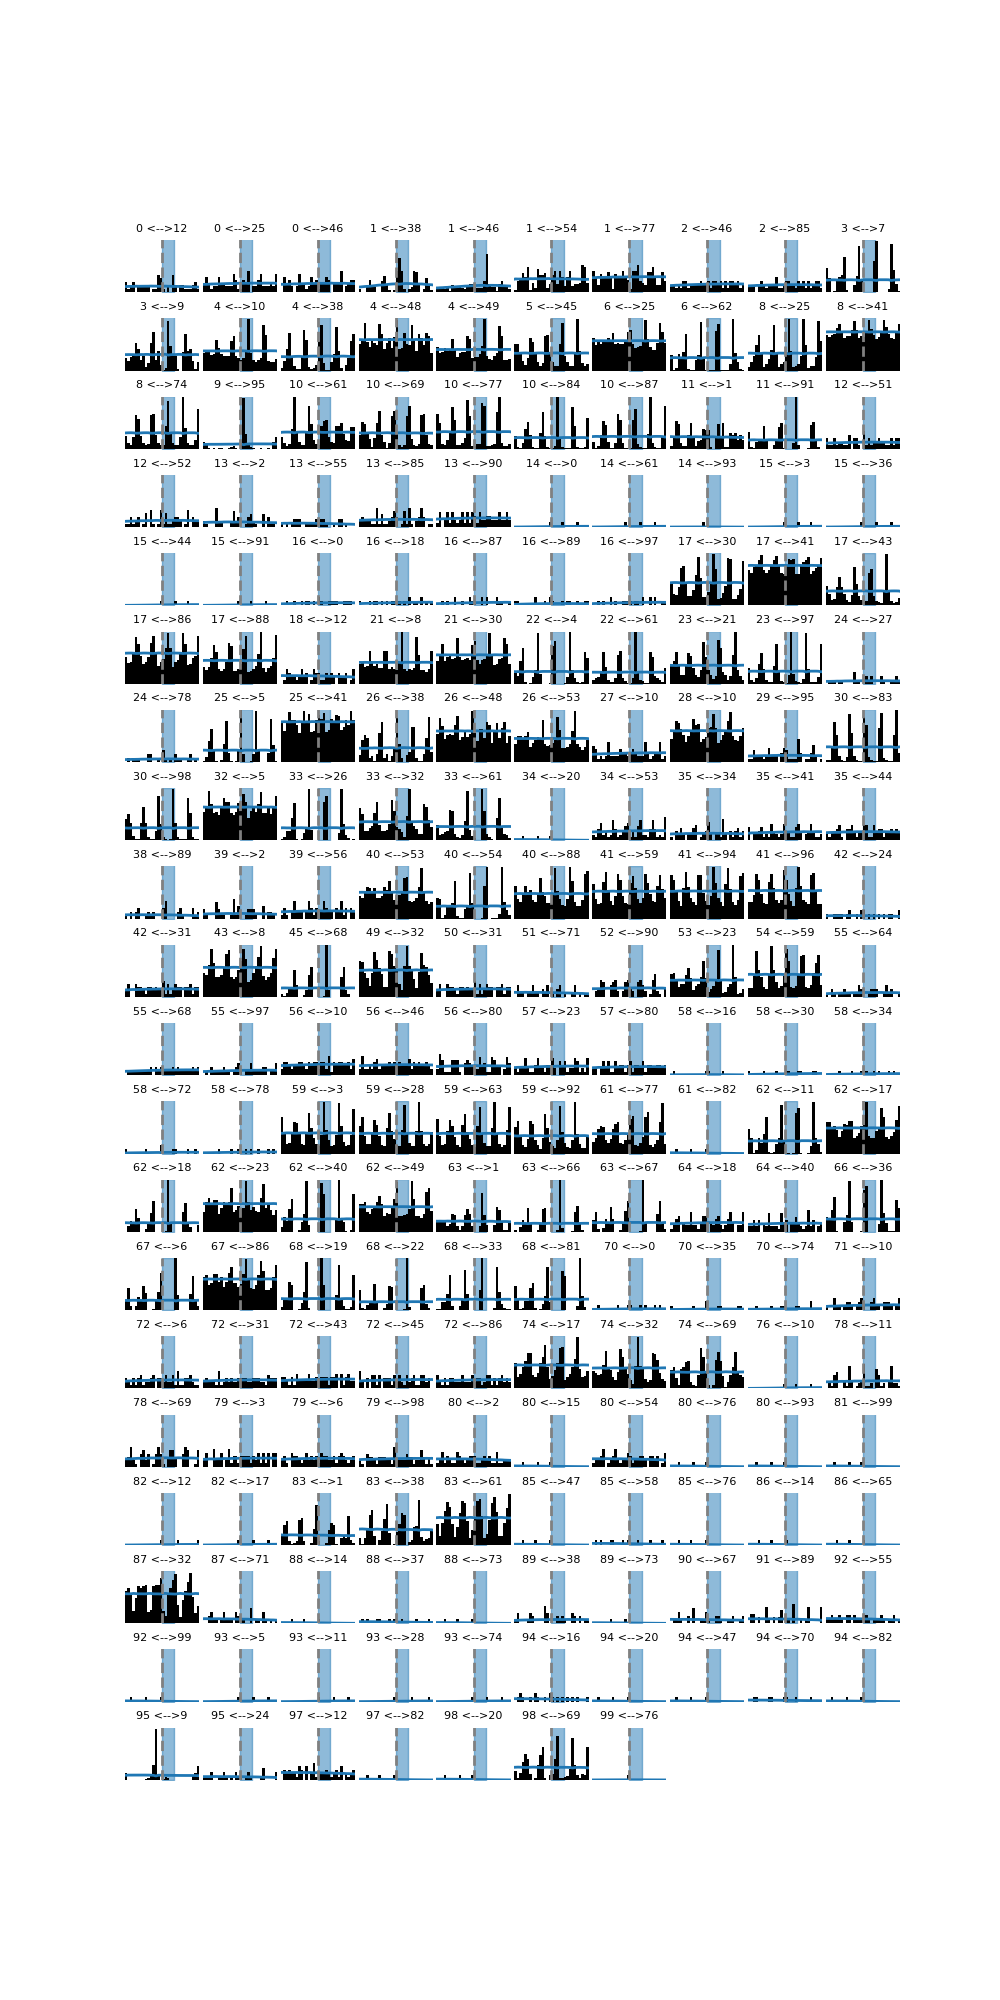

In [324]:
no_edges = len(edges)
#no_edges = 23

rows = int(no_edges/10)+1
columns = 10

fig, axs = plt.subplots(rows,columns, figsize=(10, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.05)
#fig.patch.set_facecolor('#E0E0E0')

axs = axs.ravel()

for i in range(rows*columns):
    axs[i].axis('off')

for i in range(no_edges):    
    ## get edges and ids
    # get rows/indices of marked_edges that contain connections
    edges = numpy.where(numpy.logical_and(spycon_test.marked_edges[:,2] != 0, numpy.logical_not(numpy.isnan(spycon_test.marked_edges[:,2]))))[0]
    # select arbitrary edge by order in marked edges
    idx = i
    # get pre- and post-synaptic neuron to do the CCH for
    id1, id2 = spycon_test.marked_edges[edges[idx],:2]

    ## run corr correlation 
    times1, times2 = spycon_test.times[spycon_test.ids == id1], spycon_test.times[spycon_test.ids == id2]
    counts_ccg, counts_ccg_convolved, times_ccg = visualization_english(coninf, times1, times2, 0, 3600)

    # plot
    axs[i].axis('off')

    
    axs[i].fill_between([coninf.default_params['syn_window'][0] * 1e3, coninf.default_params['syn_window'][1] * 1e3], 0, numpy.amax(counts_ccg) + 20, color='C0', alpha=.5)
    axs[i].bar(times_ccg * 1e3, counts_ccg, width=coninf.default_params['binsize'] * 1e3, color='k', label='Data CCG')
    axs[i].plot(times_ccg * 1e3, counts_ccg_convolved, 'C0', label='Smoothed CCG', lw=2)
    axs[i].vlines([0], 0, numpy.amax(counts_ccg) + 20, lw=2, ls='--', color='gray')
    #axs[i].hlines(40,-12,-8, 'r')
    #axs[i].text(-10, 47, '5 ms', color='r')
    #ax.legend()
    axs[i].set_xlim([-15,15])
    axs[i].set_xlabel('Time [ms]')
    axs[i].set_ylabel('Spike count')
    axs[i].set_ylim([0,numpy.amax(counts_ccg) + 10])
    axs[i].set_title(f'{int(id1)} <-->{int(id2)}', fontsize=8)
    
    #print(numpy.amax(counts_ccg) + 10)
    
plt.savefig('all_CCGs.pdf')  
   #plt.ion()